### NOTE:
- Luzifer settings are only saved when updated, so files without Luzi settings should inherit from earlier settings
- Alternatively: read settings from module above

In [1]:
import os
import numpy as np
from glob import glob
from os.path import join
import cv2
from tqdm import tqdm
import pickle
from welford import Welford
import pandas as pd
import strawb
import strawb.sensors.camera as camera
from strawb.config_parser import Config
import seaborn as sns
plt = sns.mpl.pyplot

# Load some files

In [2]:
db = strawb.SyncDBHandler(file_name='Default')  # loads the db
db.load_onc_db_update(save_db=True)

In [4]:
mask = (db.dataframe.deviceCode == 'TUMPMTSPECTROMETER001') # that's the pmtspec module
mask &= (db.dataframe.dataProductCode =='MSSCD') # that's the camera data of the pmtspec module

## select the file for the biolumi event
timestamp = pd.Timestamp('2022-05-01T00:00:00').tz_localize('UTC')
mask &= db.dataframe.dateFrom >= timestamp
mask &= db.dataframe.dateFrom <= timestamp + np.timedelta64(1, "D")


In [6]:
### selected one file from the DB (it's the same as the file we selected above by hand)
db.dataframe[mask].synced


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T000000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T010000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T020000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T030000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T040000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T050000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T060000.000Z-SDAQ-CAMERA.hdf5    True
/data/straw_b/raw_module_data/tumpmtspectrometer001/2022_05/TUMPMTSPECTROMETER001_20220501T0700

In [8]:
### Download the missing files which aren't synced so far from `db.dataframe[mask]`
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        save_db=True,
    )  # update the DB

update synced form          0 to          0; delta:          0
  In total: 25 files; skips synced: 0; size to download: 1.18 GB, from deviceCode: ['TUMPMTSPECTROMETER001']

-> Download the files from the ONC server
 80%|████████  | 20/25 [14:34<02:20, 28.12s/file, i=TUMPMTSPECTROMETER001_20220501T230000.000Z-SDAQ-CAMERA.hdf5]  

# convert some raw files to rgb

In [7]:
## this function is also in camera.Images, but I adapted it a bit for this analysis
def rgb_standalone(cam_run, picture_handler, bit=8, look_at=None, **kwargs):
    if look_at is None:
        look_at = np.arange(cam_run.exposure_time.shape[0])
        print(look_at)
    rgb = picture_handler.load_rgb(index=np.atleast_1d(look_at), **kwargs)
    if rgb is None:
        return None
    # get bit's right, default is 16bit
    bit_dict = {8: np.uint8, 16: np.uint16}
    if bit == 8:
        rgb = rgb / 2 ** 16 * 2 ** 8  # - 1

    rgb[rgb == 2 ** bit] = rgb[rgb == 2 ** bit] - 1
    return rgb.astype(bit_dict[bit])

## select one month of camera data
some of the data is already processed on the LRZ DSS. just check the savepath folder(s)

In [23]:
ident = "2022_05"
key = f"TUMPMTSPECTROMETER001_{ident.replace('_', '')}??T"
savepath = f"{Config.proc_data_dir}/pmtspectrometer001/dark_{ident}/"
all_files = sorted(
    glob(
        f'{Config.raw_data_dir}/tumpmtspectrometer001/{ident}/{key}??????.???Z-SDAQ-CAMERA.hdf5'
    )
)
print(len(all_files))

if os.path.isfile(join(savepath, f"{key}_biolumi_activity_info.pckl").replace("?", "x")):
    print("biolumi file already exists. continue...")
pic_path = join(savepath, "pictures")
if os.path.isdir(savepath):
    print("Savepath exists! cool:")
    print(savepath)
else:
    os.mkdir(savepath)
    print("Made this path:")
    print(savepath)
if os.path.isdir(pic_path):
    print("picpath exists! cool:")
    print(pic_path)
else:
    os.mkdir(pic_path)
    print("Made this path:")
    print(pic_path)

25
Made this path:
/data/straw_b/processed_data/pmtspectrometer001/dark_2022_05/
Made this path:
/data/straw_b/processed_data/pmtspectrometer001/dark_2022_05/pictures


## read the data, convert to RGB and built a welford object 
* this welford thingy is used to calculate mean and standard deviation iteratively so that not all data needs to be read at once
* see https://pypi.org/project/welford/ and wiki links therein
* mean and std per pixel are later used to identify outliers in the pictures

In [24]:
w = Welford()
broken_files = []
ok_files = []
for f in tqdm(all_files):
    try:
        cam_run = camera.FileHandler(f)
        ident = f.split("/")[-1].split(".")[0]
        filename = join(savepath, f"{ident}_rgb.pckl")
        ok_files.append({"fname": f, "n_frames_tot": len(cam_run.time)})
    except:
        print("Could not load file:", f)
        broken_files.append(f)
        continue
    # check if the RGB file already exists, and add it to the welford object
    if os.path.isfile(filename):
        with open(filename, "rb") as openf:
            tmp, _ = pickle.load(openf)
        w.add_all(tmp)
        continue
    # if not, load the raw pictures and convert them to RGB
    picture_handler = camera.Images(cam_run)
    try:
        this = np.where(cam_run.lucifer_options[:,0] == -125)[0]
        ok_files[-1]["n_frames_selected"] = len(cam_run.time[this])
    except:
        print(cam_run.lucifer_options)
        continue
    if this.size==0:
        print("No good pictures found.")
        continue
    try:
        tmp = rgb_standalone(cam_run, picture_handler, look_at=this, subtract_dark=False)        
        ok_files[-1]["n_frames_rgb"] = len(tmp)
    except:
        print(this)
        print("Could not compute RGB")
        continue
    # write the RBG data + timestamp to disc, so that it can be easier analyzed later on
    if tmp is not None:
        with open(filename, "wb") as openf:
            pickle.dump([tmp, cam_run.time[this].astype('datetime64[s]')], openf)
        w.add_all(tmp)
    
    # free up some space
    del cam_run
    del picture_handler
    del tmp


100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


In [9]:
### save the welford object, so that data needs to be read only once
with open(join(savepath, f"welford_{key}.pckl".replace("?", "x")), "wb") as f:
    pickle.dump(w, f)

In [27]:
# check how many files are broken
ok_df = pd.DataFrame(ok_files)
print(len(broken_files), len(ok_df), len(broken_files) + len(ok_df), len(broken_files) + len(ok_df))
print(ok_df.n_frames_selected.value_counts().sort_index())
print((ok_df.n_frames_selected - ok_df.n_frames_tot).value_counts())

0 25 25 25
34     1
35     8
36    11
37     5
Name: n_frames_selected, dtype: int64
0    25
dtype: int64


In [7]:
# once the welford object is saved, it can be read from disc instead of doing all these calculations above
# some welford objects are already saved on the DSS! see filepath above
with open(join(savepath, f"welford_{key}.pckl".replace("?", "x")), "rb") as f:
    w = pickle.load(f)

In [28]:
# get the filenames of all previously processed and saved RGB picture files
all_rgb_files = sorted(glob(join(savepath, f"{key}??????_rgb.pckl")))
print(len(all_rgb_files))

25


# Manhattan distance 
* defined as $D_M = |\Delta x| + |\Delta y|$, i.e. a rectangular distance from eg. one pixel to another one
* used to calculate distances of pixels that have a large bright std from the (dark) expectation

In [11]:
std = np.sqrt(w.var_p)

In [12]:
# settings for the cluster algorithm
# these are somewhat guessed and adapted, but not fully optimized
sigma_level = 5 # low threshold: 4; high threshold: 5
max_dist = 5
alt_max_dist = 4
cl_pix = 25 # max pixel = 60
alt_cl_pix = 15 # max pixel = 40

### CURRENTLY THE ALGORITHM IS ONLY BASED ON BLUE! 
# (it is enough in most cases anyway)
color = 2 # r: 0, g: 1, b: 2

file no. 0 of 750
found one: 2021-07-01_01-01-48
largest cluster 45 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_01-31-52
largest cluster 34 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_02-51-44
largest cluster 33 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_05-24-43
largest cluster 36 , counts 13
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_07-42-47
largest cluster 20 , counts 21
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_07-49-26
largest cluster 56 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_09-00-55
largest cluster 22 , counts 23
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_12-48-46
largest cluster 23 , counts 24
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-01_13-44-31
largest cluster 42 , counts 2
. . . . . . . . . . . . . . . . . . . . 
file no. 20 of 750
found one: 2021-07-02_06-47-13
largest cl

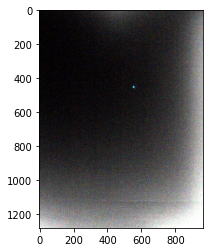

found one: 2021-07-02_14-14-29
largest cluster 60 , counts 2
. . . . . . . . . . . . . . . . . . . . 
Bright!


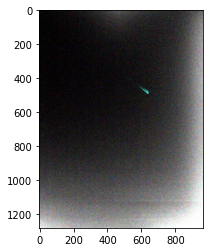

file no. 40 of 750
found one: 2021-07-02_16-02-36
largest cluster 25 , counts 26
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-02_18-32-12
largest cluster 16 , counts 17
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-02_21-35-09
largest cluster 38 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-02_22-31-40
largest cluster 21 , counts 7
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-03_01-32-52
largest cluster 16 , counts 17
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-03_03-45-49
largest cluster 19 , counts 20
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-03_07-05-17
largest cluster 15 , counts 12
. . . . . . . . . . . . . . . . . . . . 
file no. 60 of 750
found one: 2021-07-03_13-57-36
largest cluster 16 , counts 17
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-03_14-47-28
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-03_15-45-40
larges

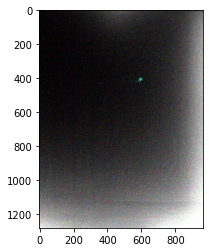

found one: 2021-07-07_17-31-36
largest cluster 19 , counts 20
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-07_17-46-33
largest cluster 60 , counts 1
. . . . . . . . . . . . . . . . . . . . 
Bright!


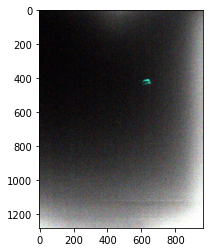

found one: 2021-07-07_18-48-04
largest cluster 17 , counts 5
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-07_19-46-13
largest cluster 30 , counts 25
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-07_20-31-04
largest cluster 41 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-07_22-10-46
largest cluster 53 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-07_22-32-23
largest cluster 29 , counts 30
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-08_01-03-38
largest cluster 52 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-08_03-40-01
largest cluster 37 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-08_04-18-17
largest cluster 20 , counts 21
. . . . . . . . . . . . . . . . . . . . 
file no. 180 of 750
found one: 2021-07-08_11-17-10
largest cluster 57 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-08_18-31-03
largest cluster 16 , counts 

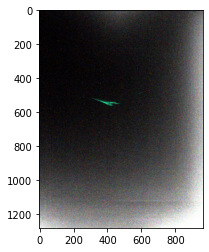

found one: 2021-07-09_08-00-30
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_09-08-39
largest cluster 18 , counts 19
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_09-30-15
largest cluster 44 , counts 4
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_10-30-05
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_11-28-14
largest cluster 15 , counts 4
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_13-59-31
largest cluster 28 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_14-14-27
largest cluster 24 , counts 25
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_20-40-07
largest cluster 22 , counts 7
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_21-01-46
largest cluster 25 , counts 26
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-09_21-11-44
largest cluster 26 , counts 1
. . . . . . . . 

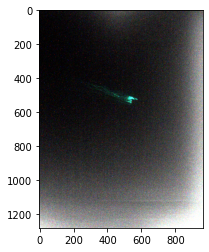

found one: 2021-07-11_08-21-40
largest cluster 28 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-11_09-31-28
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-11_09-46-25
largest cluster 40 , counts 12
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-11_10-46-15
largest cluster 22 , counts 23
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-11_12-44-20
largest cluster 29 , counts 30
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-11_13-20-54
largest cluster 35 , counts 1
. . . . . . . . . . . . . . . . . . . . 
file no. 260 of 750
found one: 2021-07-11_17-23-39
largest cluster 25 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-11_20-03-11
largest cluster 19 , counts 14
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_00-22-27
largest cluster 60 , counts 64
. . . . . . . . . . . . . . . . . . . . 
Bright!


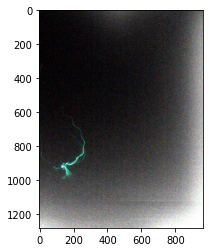

found one: 2021-07-12_00-32-25
largest cluster 25 , counts 22
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_03-43-37
largest cluster 22 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_06-26-34
largest cluster 15 , counts 14
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_08-49-27
largest cluster 19 , counts 20
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_10-32-58
largest cluster 22 , counts 23
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_11-17-48
largest cluster 31 , counts 1
. . . . . . . . . . . . . . . . . . . . 
file no. 280 of 750
found one: 2021-07-12_16-36-54
largest cluster 17 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_17-51-41
largest cluster 34 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-12_23-25-29
largest cluster 36 , counts 13
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-13_02-25-03
largest cluster 26 , coun

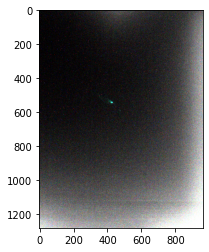

found one: 2021-07-15_10-14-19
largest cluster 17 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-15_16-25-25
largest cluster 50 , counts 1
. . . . . . . . . . . . . . . . . . . . 
file no. 360 of 750
found one: 2021-07-16_01-13-57
largest cluster 43 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_03-46-59
largest cluster 36 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_04-48-31
largest cluster 32 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_06-03-18
largest cluster 18 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_06-14-57
largest cluster 36 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_07-06-27
largest cluster 36 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_07-49-41
largest cluster 21 , counts 22
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-16_08-11-17
largest cluster 16 , counts 1

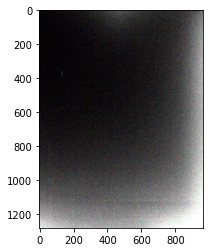

found one: 2021-07-19_13-01-12
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-19_14-02-50
largest cluster 27 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-19_14-54-22
largest cluster 19 , counts 20
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-19_17-38-52
largest cluster 21 , counts 5
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-19_21-46-28
largest cluster 16 , counts 9
. . . . . . . . . . . . . . . . . . . . 
file no. 460 of 750
found one: 2021-07-20_01-45-53
largest cluster 28 , counts 29
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-20_03-15-38
largest cluster 26 , counts 27
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-20_07-44-58
largest cluster 25 , counts 6
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-20_08-41-28
largest cluster 17 , counts 18
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-20_08-44-48
largest cluster 18 , count

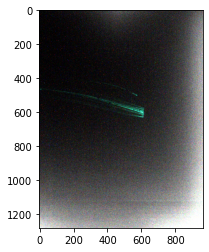

found one: 2021-07-22_06-40-51
largest cluster 60 , counts 768
. . . . . . . . . . . . . . . . . . . . 
Bright!


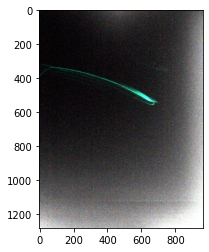

file no. 520 of 750
found one: 2021-07-22_14-49-28
largest cluster 59 , counts 1
. . . . . . . . . . . . . . . . . . . . 
Bright!


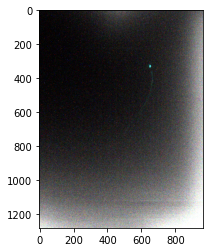

found one: 2021-07-22_16-05-57
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-22_22-48-12
largest cluster 26 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_03-54-07
largest cluster 37 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_04-57-19
largest cluster 53 , counts 2
. . . . . . . . . . . . . . . . . . . . 
file no. 540 of 750
found one: 2021-07-23_06-02-10
largest cluster 47 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_06-45-21
largest cluster 26 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_06-52-03
largest cluster 42 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_06-55-22
largest cluster 43 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_06-58-42
largest cluster 15 , counts 16
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-23_08-08-30
largest cluster 16 , counts 1

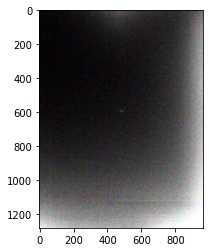

found one: 2021-07-24_07-14-57
largest cluster 27 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-24_07-48-10
largest cluster 48 , counts 5
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-24_19-07-55
largest cluster 29 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-24_20-04-25
largest cluster 60 , counts 5
. . . . . . . . . . . . . . . . . . . . 
Bright!


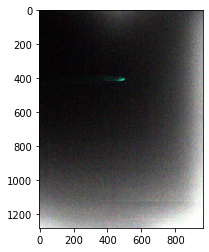

file no. 580 of 750
found one: 2021-07-24_22-49-05
largest cluster 15 , counts 4
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_03-58-25
largest cluster 46 , counts 11
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_06-16-20
largest cluster 34 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_07-02-54
largest cluster 53 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_07-11-15
largest cluster 28 , counts 29
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_13-21-55
largest cluster 16 , counts 17
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_14-21-45
largest cluster 26 , counts 4
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_14-48-21
largest cluster 60 , counts 102
. . . . . . . . . . . . . . . . . . . . 
Bright!


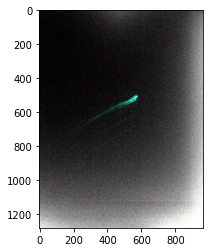

found one: 2021-07-25_15-46-31
largest cluster 18 , counts 12
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-25_16-14-46
largest cluster 58 , counts 2
. . . . . . . . . . . . . . . . . . . . 
Bright!


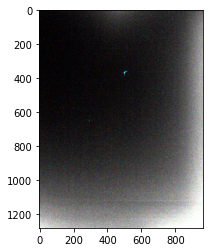

file no. 600 of 750
found one: 2021-07-26_00-18-35
largest cluster 59 , counts 6
. . . . . . . . . . . . . . . . . . . . 
Bright!


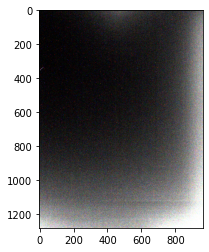

found one: 2021-07-26_06-04-27
largest cluster 42 , counts 1
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-26_07-30-57
largest cluster 16 , counts 17
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-26_08-25-47
largest cluster 17 , counts 18
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-26_13-15-04
largest cluster 60 , counts 787
. . . . . . . . . . . . . . . . . . . . 
Bright!


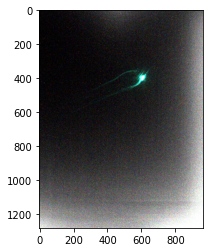

file no. 620 of 750
found one: 2021-07-26_19-42-21
largest cluster 19 , counts 20
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-26_21-37-01
largest cluster 29 , counts 4
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-26_22-26-54
largest cluster 28 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-27_02-13-03
largest cluster 23 , counts 9
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-27_02-28-02
largest cluster 44 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-27_06-09-08
largest cluster 19 , counts 17
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-27_06-59-00
largest cluster 34 , counts 3
. . . . . . . . . . . . . . . . . . . . 
file no. 640 of 750
found one: 2021-07-27_11-46-33
largest cluster 28 , counts 22
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-27_14-06-09
largest cluster 31 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-27_16-53-57
largest 

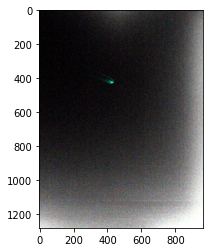

found one: 2021-07-29_16-54-37
largest cluster 16 , counts 2
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-29_17-56-04
largest cluster 31 , counts 30
. . . . . . . . . . . . . . . . . . . . 
file no. 700 of 750
found one: 2021-07-30_06-09-18
largest cluster 28 , counts 19
. . . . . . . . . . . . . . . . . . . . 
file no. 720 of 750
found one: 2021-07-31_02-37-28
largest cluster 16 , counts 8
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-31_02-45-46
largest cluster 34 , counts 20
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-31_03-57-11
largest cluster 37 , counts 3
. . . . . . . . . . . . . . . . . . . . 
found one: 2021-07-31_06-11-46
largest cluster 15 , counts 6
. . . . . . . . . . . . . . . . . . . . 
file no. 740 of 750
found one: 2021-07-31_23-24-05
largest cluster 60 , counts 16
. . . . . . . . . . . . . . . . . . . . 
Bright!


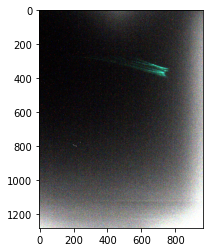

Done


In [13]:
list_of_timestamps = []
total_number_of_pictures = 0

# loop over all RGB pictures and identify outliers based on parameters above
for ff,f in enumerate(all_rgb_files):
    if ff%20==0: print("file no.", ff, "of", len(all_rgb_files))
    with open(f, "rb") as filo:
        tmp, times = pickle.load(filo)
        total_number_of_pictures += len(times)
    
    # select pixels where the brightness exceeds the mean by several std
    mask = tmp - w.mean > sigma_level * std
    # .. and prepare to count them
    mask = np.logical_and(mask, std > 0).astype(int)

    # mask contains all RGB files per camera file, loop over all pictures
    for im, m in enumerate(mask):
        fname_id = str(times[im]).replace(":", "-").replace("T", "_")
        filename = join(savepath, f"./pictures/{fname_id}.png")

        # if the picture is already analyzed and saved to disc, skip!
        # this needs to be removed when eg. changing the algorithm
        # such that it's re-analyzed
        if os.path.isfile(filename):
            continue

        # just selecting the blue channel for now
        # shape: n_pixel x 2 (x and y coordinates of the picture)
        # get the x and y coordinates (=indices) from the mask
        indices = np.array(np.where(m[:,:,color])).T
        # catch pictures that are super bright, however that happened..??
        if indices.shape[0] > 1E4:
            print("Super bright picture:", fname_id)
            continue
        # calculate manhattan distance of bright selected pixels to each other
        # n_pixel x n_pixel
        manhattan_distance = np.abs(
            indices[:,:,np.newaxis] - indices.T).sum(axis=1)

        # select neighboring pixels within a max distances, per pixel
        cluster_sum_mask = np.logical_and(
            manhattan_distance <= max_dist,
            manhattan_distance > 0 # ensure that the pixel itself is not counted
        )

        # count the neighboring pixels, per pixel
        cluster_sum = cluster_sum_mask.sum(axis=0)
        # define a cluster with cl_pix neighboring pixels or more 
        number_of_clusters = np.count_nonzero(cluster_sum >= cl_pix)
        thresh = cl_pix
        
        # if there are no clusters found, try some slightly different settings for the algorithm
        if number_of_clusters <= 1:
            # alternative criterion: smaller cluster, but 2 or more of them
            cluster_sum_mask = np.logical_and(
                manhattan_distance <= alt_cl_pix,
                manhattan_distance > 0
            )
            cluster_sum = cluster_sum_mask.sum(axis=0)
            alt_num = np.count_nonzero(cluster_sum >= alt_cl_pix)
            thresh = alt_cl_pix
            
        if number_of_clusters >= 1 or alt_num >= 2:
            # count the number of clusters
            unq, ct = np.unique(cluster_sum, return_counts=True)
            # classify
            if unq[-1] >= 58: brightness = "bright"
            elif unq[-1] >= 37: brightness = "medium"
            else: brightness = "dim"
            
            
            print("found one:", fname_id)
            print("largest cluster", unq[-1], ", counts", ct[-1])

            # save all info            
            list_of_timestamps.append({
                "timestamp": times[im],
                "cluster_type": "normal" if number_of_clusters >= 1 else "alt",
                "brightness": brightness
                #"cluster_positions": pixel_clusters
            })            
            
            print(". . " * 10)
            cv2.imwrite(filename, tmp[im,:,:,::-1])
            # in case the cluster is bright, show the picture
            # and save it for outreach purposes :D
            # dimmer pictures can be retrieved from the list_of_timestamps
            if unq[-1] >=58:
                print("Bright!")
                cv2.imwrite(f"./figures/bright_{fname_id}.png", tmp[im,:,:,::-1])
                plt.figure()
                plt.imshow(tmp[im,:,:]/255)
                plt.show()
        del indices
    del mask
    del tmp
            
print("Done")

In [14]:
# save the meta info of the pictures
pd_info = pd.DataFrame(list_of_timestamps)
pd_info.to_pickle(join(savepath, f"biolumi_activity_info.pckl"))

In [15]:
# gives a number of how many pictures contain bright biolumi activity
len(pd_info) / total_number_of_pictures

0.010376231710958495

In [16]:
pd_info

,timestamp,cluster_type,brightness
0,2021-07-01 01:01:48,normal,medium
1,2021-07-01 01:31:52,normal,dim
2,2021-07-01 02:51:44,alt,dim
3,2021-07-01 05:24:43,normal,dim
4,2021-07-01 07:42:47,alt,dim
...,...,...,...
273,2021-07-31 02:37:28,alt,dim
274,2021-07-31 02:45:46,normal,dim
275,2021-07-31 03:57:11,normal,medium
276,2021-07-31 06:11:46,alt,dim


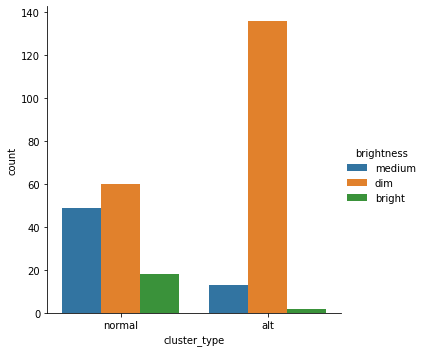

In [17]:
sns.catplot(data=pd_info, x="cluster_type", hue="brightness", kind="count" )

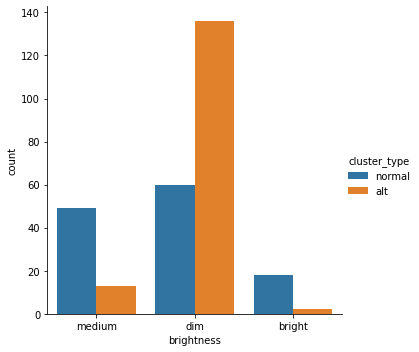

In [18]:
sns.catplot(data=pd_info, hue="cluster_type", x="brightness", kind="count" )

In [22]:
pd_info.loc[(pd_info.cluster_type=="alt") & (pd_info.brightness!="dim")]

,timestamp,cluster_type,brightness
7,2021-09-01 17:23:24,alt,medium
31,2021-09-08 13:07:34,alt,medium
54,2021-09-14 00:35:17,alt,medium
56,2021-09-14 05:04:33,alt,medium
81,2021-09-16 00:14:38,alt,medium
101,2021-09-17 16:24:15,alt,medium
153,2021-09-22 01:43:08,alt,medium
167,2021-09-24 04:10:10,alt,medium
231,2021-09-30 13:06:22,alt,medium
